# **MAAS User Interface**

Este notebook detalla la interfaz a utilizar para ejecutar MAAS. Funciona en Google Colab y en JupyterLab.

JupyterLab:
- Se solicitará el nombre (sin extensión) de un archivo WAV a 44100 Hz, colocado en en /samples/
- Se preguntará si gusta guardar el CSV generado con MAAS_filter() en /database/
- Funciona Out Of The Box, siempre que tenga toda la paquetería requerida (np, IPython, soundfile, scipy, matplotlib)

Colab:
- Puede utilizar el micrófono y grabar (si la sesión es nueva, puede que requiera de dos intentos por cuestiones de permisos)
- No se guardará ningún CSV
- Debe cargar la base de datos (/database/*.csv)
- Debe cargar el módulo MAAS_Filters.ipynb a la raíz de la sesión, que se incluye en el GitHub

- Diego Casta - 35705
- Mauricio Alcántar - 35860
- David Santana - 35967

## **Librerías**

In [1]:
import numpy as np
from io import BytesIO
from base64 import b64decode
try:
    from google.colab import output
except ImportError:
    pass
from IPython.display import Javascript
import IPython.display as ipd
import io
import soundfile as sf
from scipy import signal as sig
from scipy.io import wavfile as wav
from os import listdir

In [2]:
IN_COLAB = None
if 'google.colab' in str(get_ipython()):
  IN_COLAB = True
  print('Ejecutándose en Colab')
else:
  IN_COLAB = False
  print('Ejecutándose localmente')

Ejecutándose localmente


In [3]:
if IN_COLAB:
  !pip install ipython-autotime

In [4]:
%load_ext autotime

time: 0 ns (started: 2024-11-27 15:49:45 -08:00)


## **Lectura de archivo**

In [5]:
RECORD = None if not IN_COLAB else """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time));

const b2text = blob => new Promise(resolve => {
  const reader = new FileReader();
  reader.onloadend = e => resolve(e.srcElement.result);
  reader.readAsDataURL(blob);
});

var record = time => new Promise(async resolve => {
  const stream = await navigator.mediaDevices.getUserMedia({ audio: true });
  const audioContext = new AudioContext({ sampleRate: 44100 });
  const source = audioContext.createMediaStreamSource(stream);
  const recorder = new MediaRecorder(stream);
  let chunks = [];

  recorder.ondataavailable = e => chunks.push(e.data);
  alert("Presiona 'aceptar' para empezar la grabación.");
  recorder.start();
  await sleep(time);

  recorder.onstop = async () => {
    const blob = new Blob(chunks, { type: 'audio/ogg; codecs=opus' });
    const arrayBuffer = await blob.arrayBuffer();
    const audioBuffer = await audioContext.decodeAudioData(arrayBuffer);

    // Convert to WAV format
    const wavBlob = encodeWAV(audioBuffer, 44100, 16);
    const wavText = await b2text(wavBlob);
    resolve(wavText);

    // Clean up
    stream.getTracks().forEach(track => track.stop());
    audioContext.close();
  };

  recorder.stop();
});

// WAV encoding function
function encodeWAV(audioBuffer, sampleRate, bitDepth) {
  const numChannels = audioBuffer.numberOfChannels;
  const length = audioBuffer.length * numChannels * (bitDepth / 8);
  const buffer = new ArrayBuffer(44 + length);
  const view = new DataView(buffer);

  // WAV header
  writeString(view, 0, 'RIFF');
  view.setUint32(4, 36 + length, true);
  writeString(view, 8, 'WAVE');
  writeString(view, 12, 'fmt ');
  view.setUint32(16, 16, true);  // Format chunk length
  view.setUint16(20, 1, true);   // PCM format
  view.setUint16(22, numChannels, true);
  view.setUint32(24, sampleRate, true);
  view.setUint32(28, sampleRate * numChannels * (bitDepth / 8), true); // Byte rate
  view.setUint16(32, numChannels * (bitDepth / 8), true); // Block align
  view.setUint16(34, bitDepth, true); // Bits per sample
  writeString(view, 36, 'data');
  view.setUint32(40, length, true);

  // Write PCM samples
  let offset = 44;
  for (let channel = 0; channel < numChannels; channel++) {
    const data = audioBuffer.getChannelData(channel);
    for (let i = 0; i < data.length; i++, offset += 2) {
      const sample = Math.max(-1, Math.min(1, data[i]));
      view.setInt16(offset, sample < 0 ? sample * 0x8000 : sample * 0x7FFF, true);
    }
  }

  return new Blob([view], { type: 'audio/wav' });
}

function writeString(view, offset, string) {
  for (let i = 0; i < string.length; i++) {
    view.setUint8(offset + i, string.charCodeAt(i));
  }
}
"""

def record(sec=10):
  output.eval_js(RECORD)
  sec += 1
  s = output.eval_js('record(%d)' % (sec*1000))
  print("Grabación terminada")
  b = b64decode(s.split(',')[1])
  return b #byte stream

time: 16 ms (started: 2024-11-27 15:49:45 -08:00)


In [6]:
audio = input() if not IN_COLAB else record(10)

 ladelamalasuerte


time: 2.86 s (started: 2024-11-27 15:49:45 -08:00)


time: 14.6 s (started: 2024-11-22 00:54:55 -08:00)


In [7]:
ipd.display(ipd.Audio(audio if IN_COLAB else './samples/' + audio + '.wav'))

time: 47 ms (started: 2024-11-27 15:49:48 -08:00)


In [8]:
data, sr = None, None
if (IN_COLAB): data, sr = sf.read(io.BytesIO(audio))
else: sr, data = wav.read('./samples/' + audio + '.wav')
if (data.ndim == 2): data = data.mean(axis=1).astype(data.dtype)
print("Sample rate is {0}Hz".format(sr))

Sample rate is 44100Hz
time: 0 ns (started: 2024-11-27 15:49:48 -08:00)


C:\Users\HakkinDavid\AppData\Local\Temp\ipykernel_21356\3546211360.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  else: sr, data = wav.read('./samples/' + audio + '.wav')


In [9]:
if (IN_COLAB):
  %run /content/MAAS_Filters.ipynb
else:
  %run ./MAAS_Filters.ipynb

time: 391 ms (started: 2024-11-27 15:49:48 -08:00)


¿Guardar CSV? [y/N] y


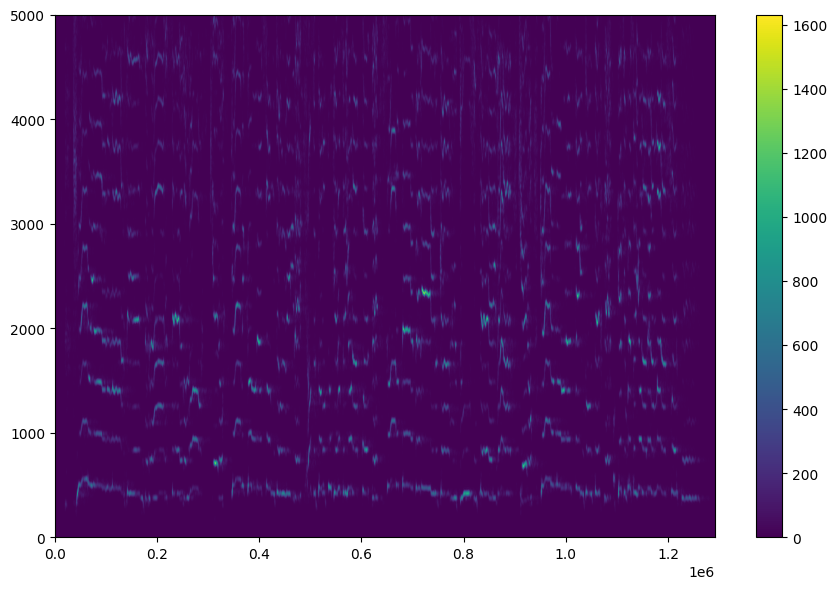

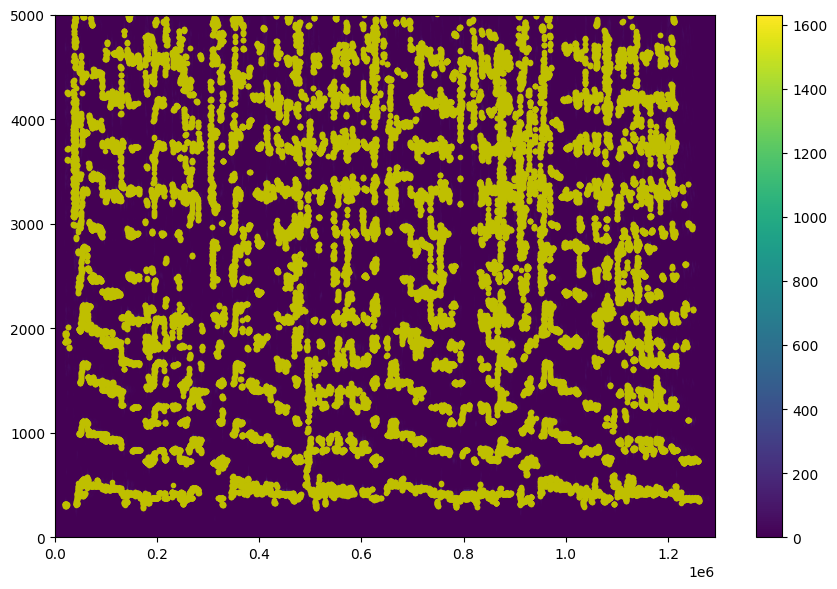

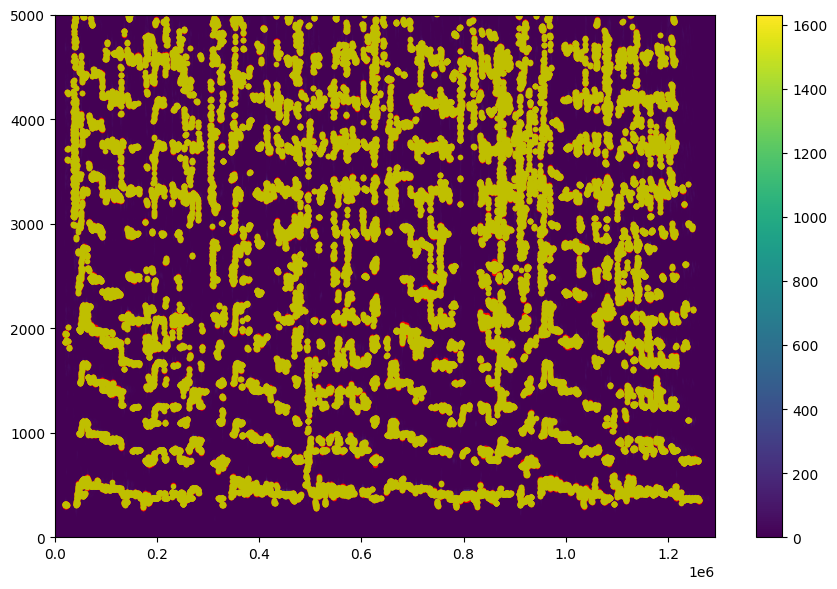

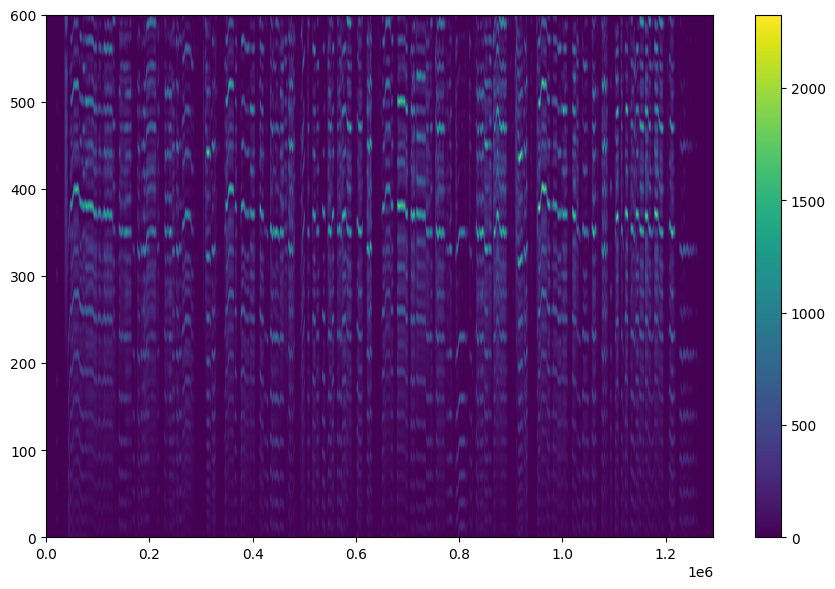

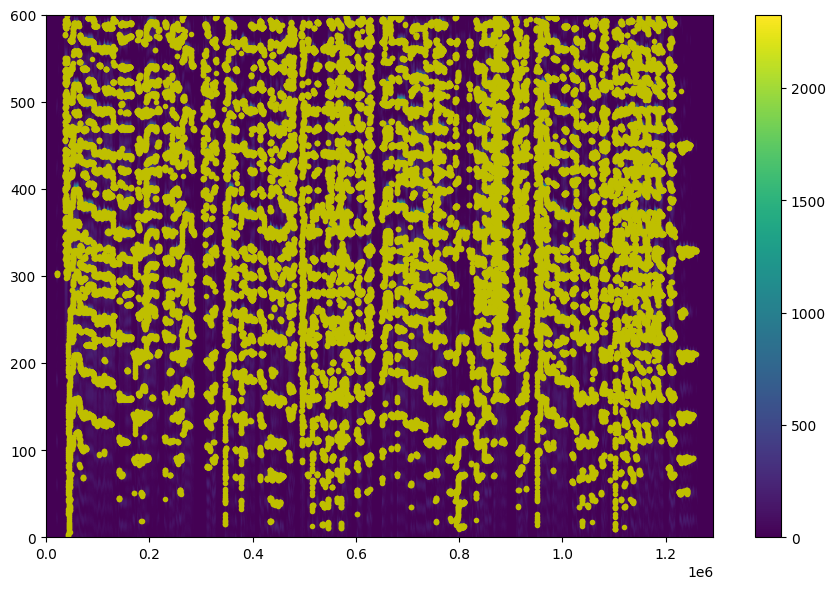

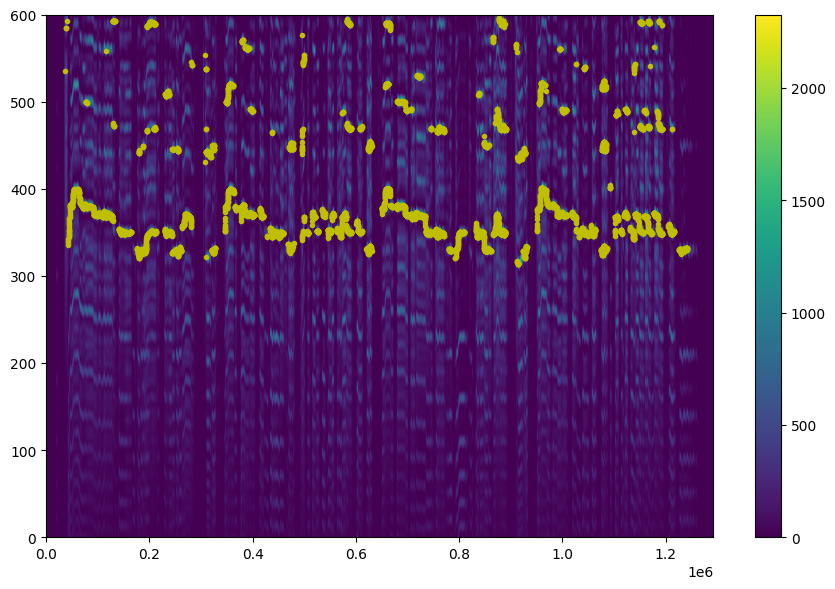

C:\Users\HakkinDavid\AppData\Local\Temp\ipykernel_21356\2997397930.py:320: UserWarning: Adding colorbar to a different Figure <Figure size 900x600 with 3 Axes> than <Figure size 900x600 with 1 Axes> which fig.colorbar is called on.
  fig1.colorbar(im1)


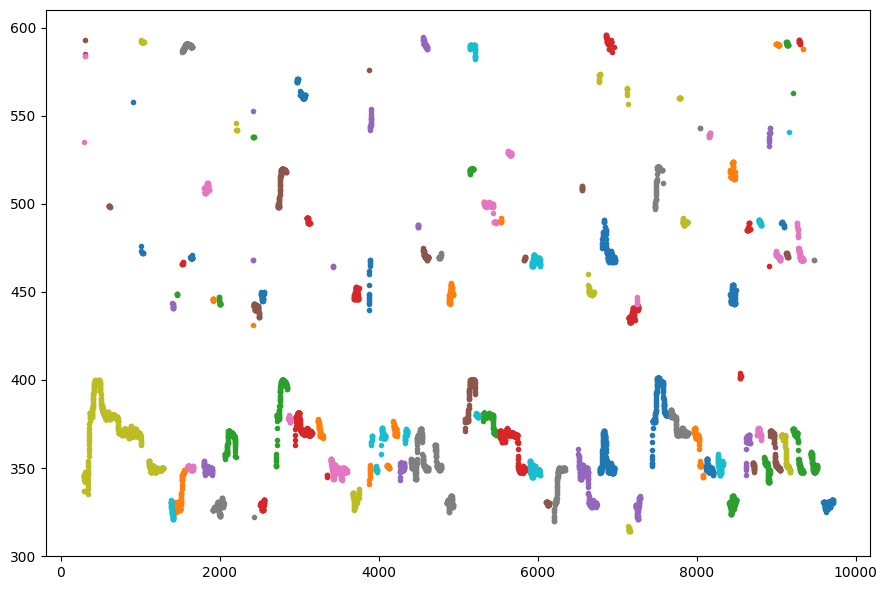

C:\Users\HakkinDavid\AppData\Local\Temp\ipykernel_21356\2997397930.py:351: UserWarning: Adding colorbar to a different Figure <Figure size 900x600 with 4 Axes> than <Figure size 900x600 with 1 Axes> which fig.colorbar is called on.
  fig1.colorbar(im1)


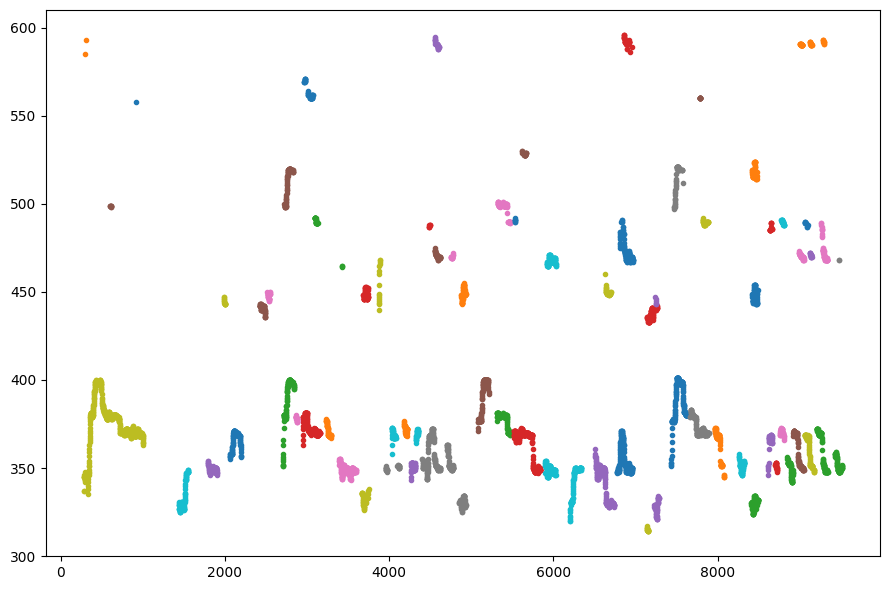

C:\Users\HakkinDavid\.conda\envs\MAAS\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\HakkinDavid\.conda\envs\MAAS\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\HakkinDavid\AppData\Local\Temp\ipykernel_21356\2997397930.py:486: UserWarning: Adding colorbar to a different Figure <Figure size 900x600 with 5 Axes> than <Figure size 900x600 with 1 Axes> which fig.colorbar is called on.
  fig1.colorbar(im1)


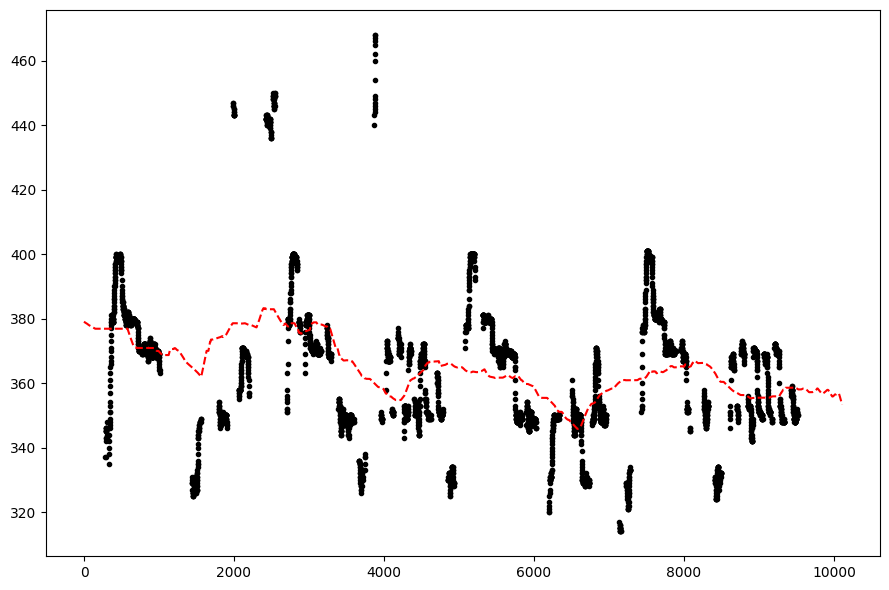

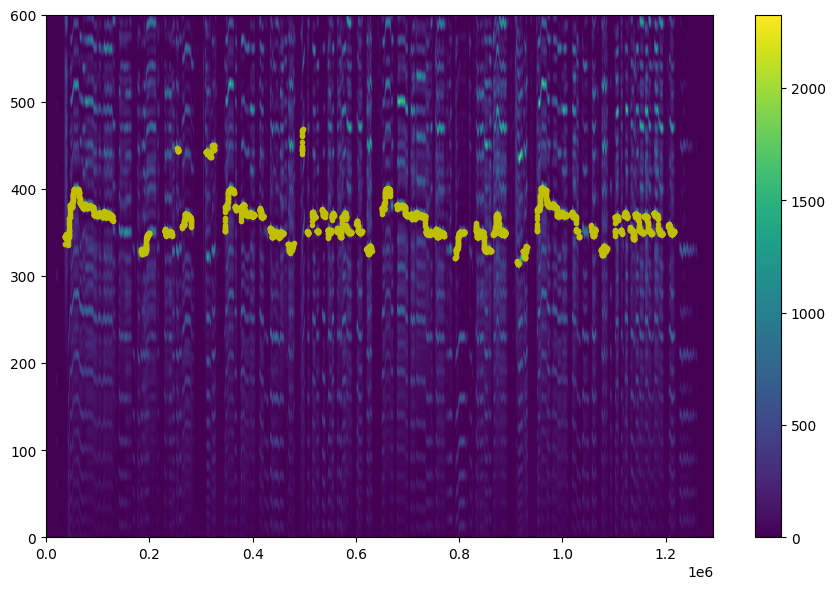

time: 2min 6s (started: 2024-11-27 15:49:48 -08:00)


In [10]:
filtered = MAAS_filter(data, sr, None if (IN_COLAB or input('¿Guardar CSV? [y/N]').lower() != 'y') else './database/' + audio + '.csv')

In [11]:
filtered

[array([7434, 7435, 7436, ..., 6336, 6337, 6338]),
 array([351, 352, 353, ..., 350, 349, 349])]

time: 0 ns (started: 2024-11-27 15:51:54 -08:00)


In [12]:
import matplotlib.pyplot as plt
import math

time: 0 ns (started: 2024-11-27 15:51:54 -08:00)


In [13]:
def LinearRegressionMAAS(timepairsRec,timepairsTest,details):
  timepairsRec = np.array(timepairsRec)
  timepairsTest = np.array(timepairsTest)
  n = len(timepairsRec)
  xi = timepairsRec
  yi = timepairsTest
  xi2=xi**2
  yi2=yi**2
  xiyi=xi*yi
  table=np.transpose([xi,yi,xi2,yi2,xiyi])
  xiS=np.sum(xi)
  yiS=np.sum(yi)
  xi2S=np.sum(xi2)
  yi2S=np.sum(yi2)
  xiyiS=np.sum(xiyi)
  sumApp=([xiS,yiS,xi2S,np.around(yi2S,decimals=2),xiyiS])  # Creacion de la tabla de sumatorias

  # Paso 1. Calculo de a1
  a1=(n*(xiyiS)-(xiS*yiS))/(n*xi2S-(xiS**2))
  xProm=xiS/n
  yProm=yiS/n

  # Paso 2. Calculo de a0
  a0=yProm-(a1*xProm)

  # Coeficiente de correlacion
  r=(n*xiyiS - (xiS*yiS))/((math.sqrt(n*(xi2S)-(xiS**2)))*(math.sqrt(n*(yi2S)-(yiS**2))))

  # Desviacion estandar
  sig=math.sqrt(((n*(yi2S))-(yiS**2))/(n*(n-1)))

  # Graficacion
  yG= a1*xi + a0
  plt.plot(xi,yG,'bo-')
  plt.plot(xi,yi,'ko')
  plt.grid()
  plt.title("Window")
  plt.xticks(xi)
  plt.show()
  print("r =",np.around(r,decimals=6),"\nr^2 =",np.around(r**2,decimals=6))
  if(details):
    print("a1 =",np.around(a1,decimals=6))
    print("a0 =",np.around(a0,decimals=6))
    print("y =",np.around(a1,decimals=4),"x +",np.around(a0,decimals=4))
    print("Desviación estándar:",np.around(sig,decimals=4))
    print()
  return (r)


time: 0 ns (started: 2024-11-27 15:51:54 -08:00)


In [14]:
def SlidingWindowRegression(recording_song,test_song,step_size, silent = True):

  n = len(recording_song)
  m = test_song.shape[1]
  r_arr = []
  count = 0
  for i in range(0, m-n+1, step_size):
   current = test_song[:,i:i+n]
   timepairsRec = []
   timepairsTest = []
   for j in range(current.shape[1]):

      if(abs(current[1,j] - recording_song[1][j]) < 5):

        timepairsRec.append(recording_song[0][j])
        timepairsTest.append(current[0,j])

   count += 1

   if len(timepairsRec) > 1 and len(timepairsTest) > 1:
     r = (LinearRegressionMAAS(timepairsRec,timepairsTest,False))**2
     r_arr = np.append(r_arr,r)
     if (not silent): print(f'Window {count} done successfully.')

   else:
     if (not silent): print(f'Window {count} done, no pairs found.')

  if (np.any(r_arr)):
    return(np.max(r_arr))

  else:
    if (not silent): print("Zero matches.\n")

    return(0)

time: 0 ns (started: 2024-11-27 15:51:54 -08:00)


In [15]:
def get_database():
    filenames = listdir("/content/" if IN_COLAB else "./database/")
    return [ filename for filename in filenames if filename.endswith( ".csv" ) ]

time: 0 ns (started: 2024-11-27 15:51:54 -08:00)


In [16]:
def compare(filtered_song, db_obj, silent = True):
    test_song = np.transpose(np.genfromtxt(("/content/" if IN_COLAB else "./database/") + db_obj, delimiter=",", skip_header=1))
    
    #test_song is an np array
    #filtered is a python list
    
    n = len(filtered_song[1])
    
    # SlidingWindowRegression already squares 'r'
    r2 = SlidingWindowRegression(filtered_song,test_song,75)
    
    if (r2):
      if (not silent): print("Best R^2:", r2)
    else:
      if (not silent): print(f"Zero correlation found for {db_obj}.")
    return r2

time: 16 ms (started: 2024-11-27 15:51:54 -08:00)


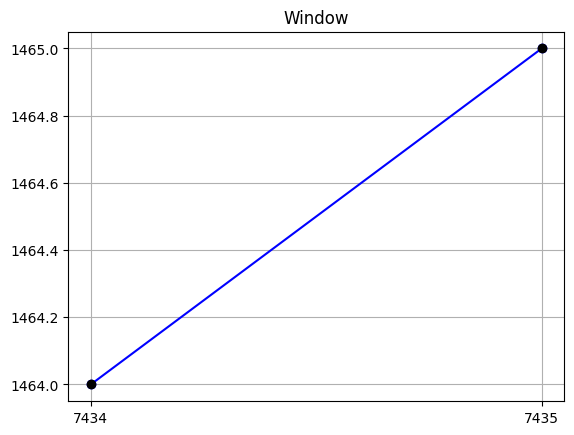

r = 1.0 
r^2 = 1.0


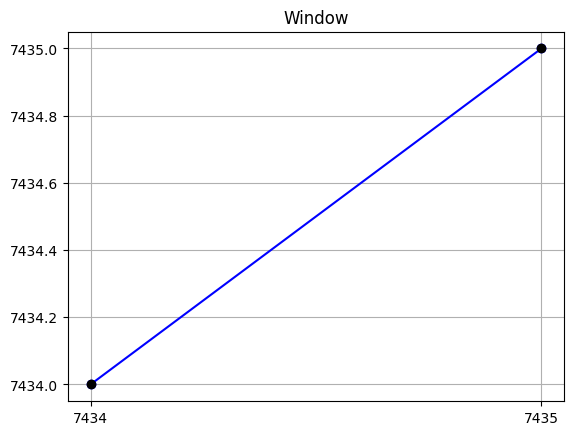

r = 1.0 
r^2 = 1.0


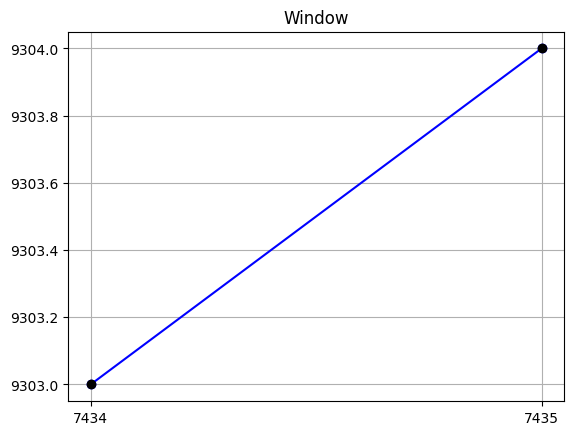

r = 1.0 
r^2 = 1.0


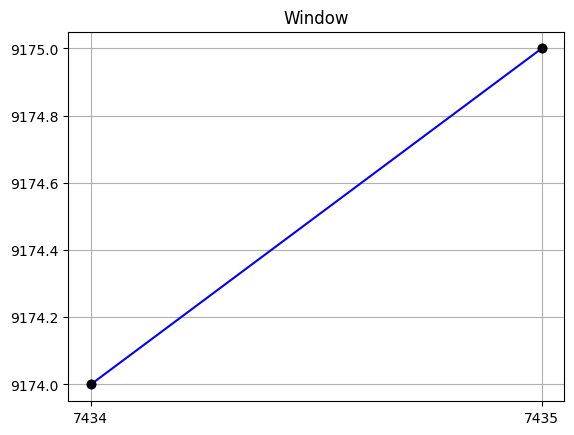

r = 1.0 
r^2 = 1.0


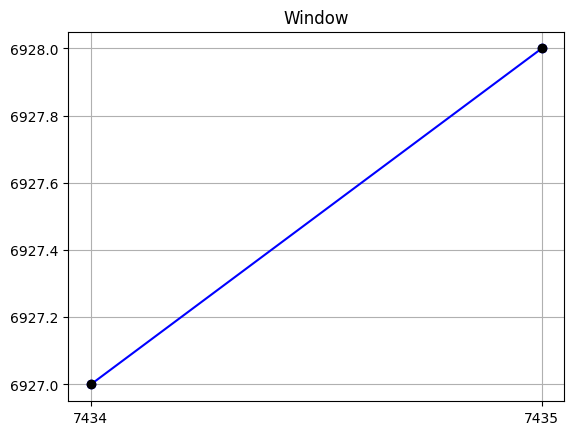

r = 1.0 
r^2 = 1.0


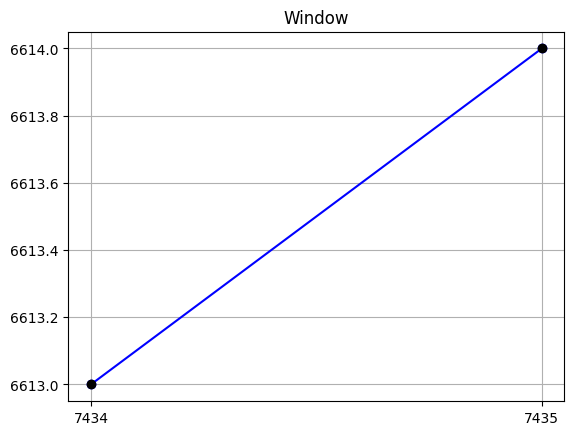

r = 1.0 
r^2 = 1.0


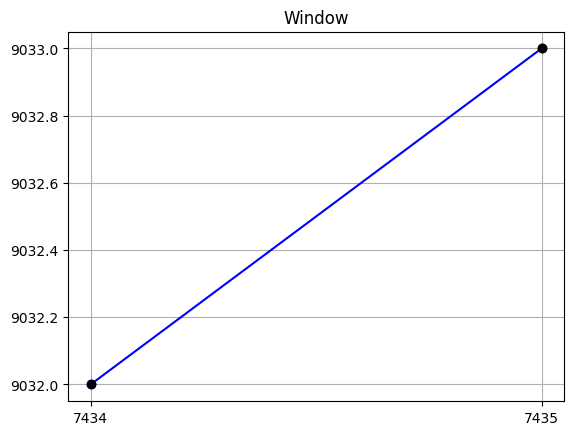

r = 1.0 
r^2 = 1.0


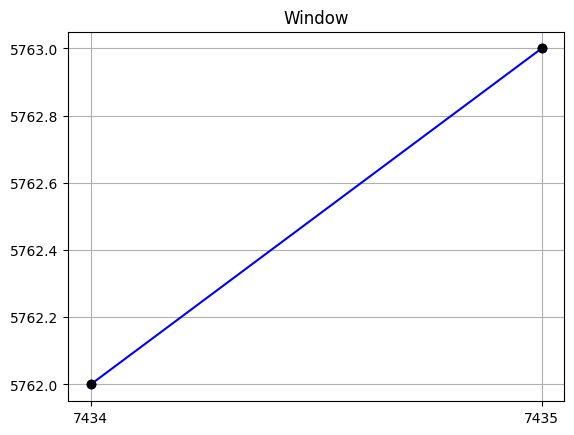

r = 1.0 
r^2 = 1.0


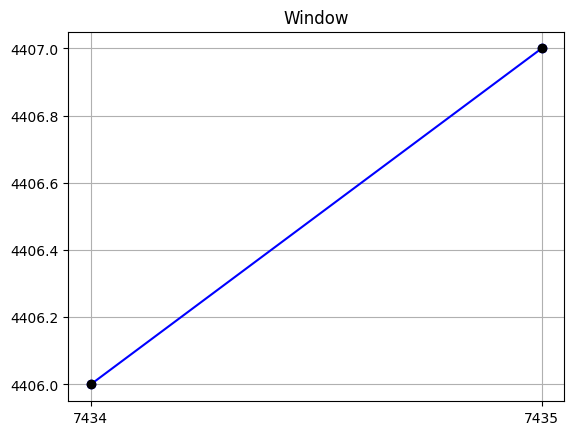

r = 1.0 
r^2 = 1.0


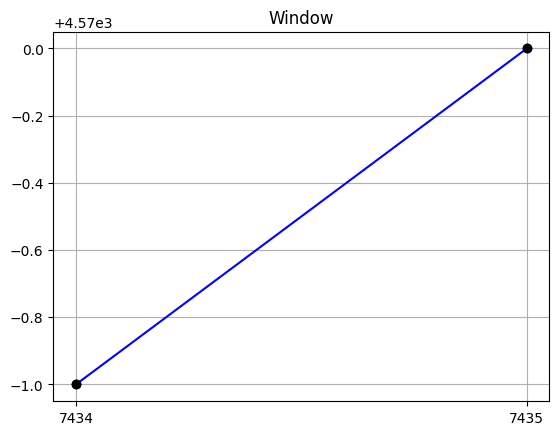

r = 1.0 
r^2 = 1.0


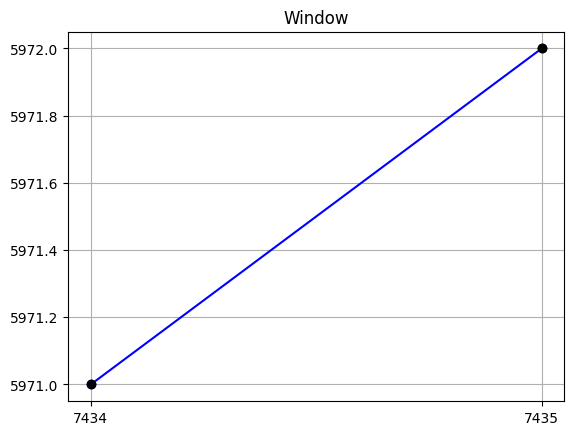

r = 1.0 
r^2 = 1.0


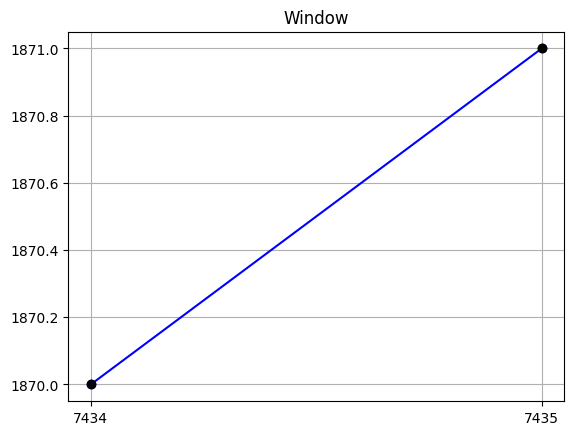

r = 1.0 
r^2 = 1.0


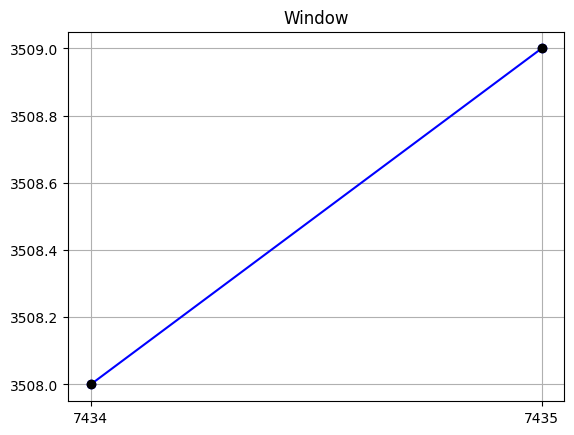

r = 1.0 
r^2 = 1.0


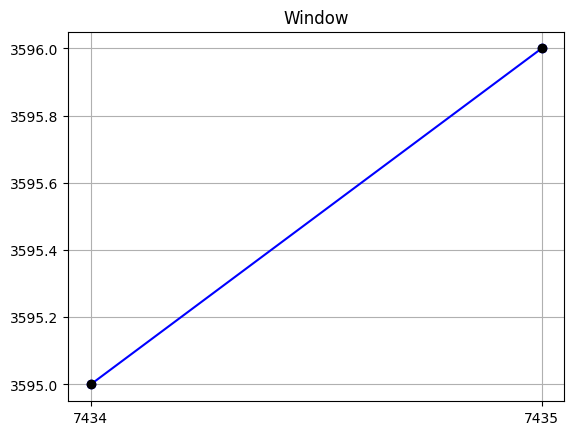

r = 1.0 
r^2 = 1.0


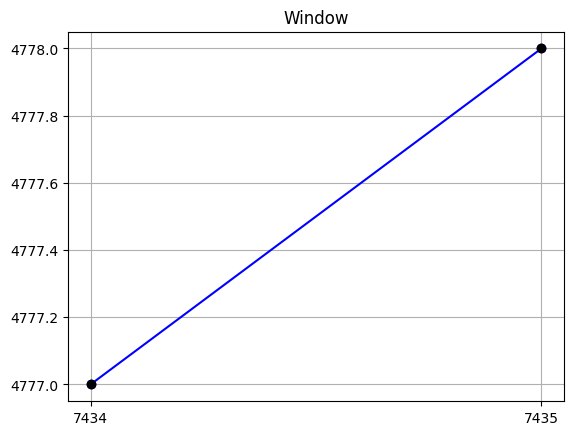

r = 1.0 
r^2 = 1.0


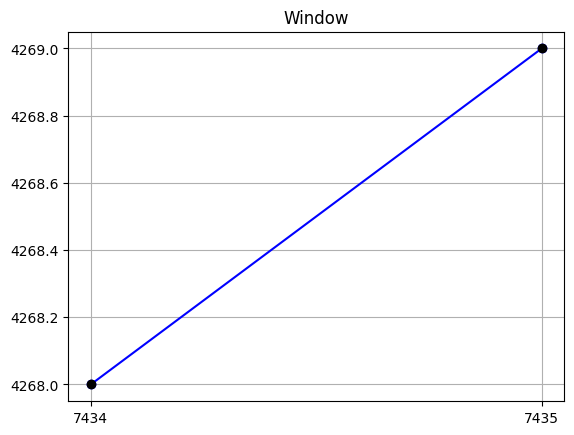

r = 1.0 
r^2 = 1.0


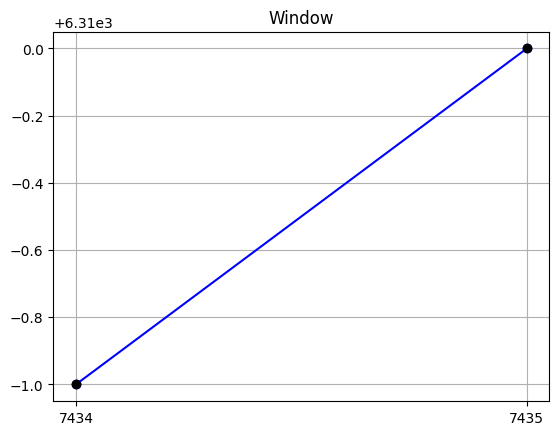

r = 1.0 
r^2 = 1.0
La canción identificada fue caradenada.csv
time: 718 ms (started: 2024-11-27 15:51:54 -08:00)


In [17]:
database = get_database()
results = {}
for SONG in database:
    results[SONG] = compare(filtered, SONG)

print(f"La canción identificada fue {max(results, key=results.get)}")